In [1]:
import numpy as np
from numpy import linalg as LA
import torch
from torch import nn
import tqdm
import torch.nn.utils
import matplotlib.pyplot as plt
import einops
from torch.nn import functional as F


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
from typing import Optional

# Demonstrating Superposition

In [24]:
class Model(torch.nn.Module):
    def __init__(self,n_features, n_hidden, S, n_instances=10, active=True):
        super().__init__()
        self.W = torch.nn.Parameter(torch.empty((n_instances, n_features, n_hidden)))
        torch.nn.init.xavier_normal_(self.W)
        self.b_final = torch.nn.Parameter(torch.zeros((n_instances, n_features)))
        self.active = active
        
        self.feature_probability = S
        self.n_instances = n_instances
        self.n_features = n_features
    
        
    def forward(self, features):

        hidden = torch.einsum("...if,ifh->...ih", features, self.W)
#         if self.active:
#             hidden = F.relu(hidden)

        out = torch.einsum("...ih,ifh->...if", hidden, self.W)

        out = out + self.b_final
        if self.active:
            out = F.relu(out)
        return out
    
    def generate_batch(self, n_batch):
        feat = torch.rand((n_batch, self.n_instances, self.n_features))
        batch = torch.where(
            torch.rand((n_batch, self.n_instances, self.n_features)) <= self.feature_probability,
            feat,
            torch.zeros(()),
        )
        return batch

In [38]:
def learning(model, x, importances, n, epoch=10000, lr=0.001, batch_size=100):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    
    for epoch in tqdm.tqdm(range(epoch)):
        
        importances = torch.tensor([I**k for k in range(n)])

        optimizer.zero_grad()

        batch = model.generate_batch(batch_size)
        
        out = model(batch)
        
        error = (importances*(batch.abs() - out)**2)
        loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
        
        loss.backward() 

        optimizer.step() 
        
    return model


In [5]:
def paint_WtW(model, S):    
    for i in range(len(S)):
        WtW = torch.mm(model.W[i], model.W[i].T)
        plt.matshow(WtW.detach().numpy())
        plt.colorbar(ticks=[-1, -0.5, 0, 0.5, 1])
        plt.title("S = "+ str("{:.3f}".format(S[i].item())))
        plt.clim(-1,1)
        plt.imshow
        #plt.savefig("WtW_"+str(S[i])+".pdf")

In [6]:
def paint_b(model, S): 
    for i in range(len(S)):
        plt.matshow(model.b_final[i].detach().numpy().reshape(-1,1))
        plt.axis('off')
        plt.colorbar(ticks=[-1, -0.5, 0, 0.5, 1])
        plt.title("S ="+ str("{:.3f}".format(S[i].item())))
        plt.clim(-1,1)
        #plt.savefig("b_"+str(S[i])+".pdf")

In [ ]:
def paint_norm(model, n):
    
    W = model.W.detach()
    W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))

    interference = torch.einsum('ifh,igh->ifg', W_norm, W)
    interference[:, torch.arange(n), torch.arange(n)] = 0
    
    

    
    polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()

    for i in range(len(S)):
        norm_list = torch.norm(model.W[i], dim=1).tolist()
    

        color_value = polysemanticity[i].detach().numpy()
        colors = np.array(['colors' for i in range (len(color_value))])
        colors[color_value <= 0.2] = 'black'
        colors[(0.2 < color_value) & (color_value <= 0.4)] = 'purple' 
        colors[(0.4 < color_value) & (color_value <=  0.6)] = 'blue'
        colors[(0.6 < color_value) & (color_value <=  0.8)] = 'green'
        colors[0.8 < color_value] = 'yellow'

        fig, ax = plt.subplots()


    

        ax.barh([i for i in range(len(polysemanticity[i]))],norm_list[::-1], color=colors[::-1])

        plt.title("S ="+ str("{:.3f}".format(S[i].item())))

# n = 20, m = 5, I = 0.7, num = 10000

In [7]:
n = 20
m = 5
I = 0.7
num = 10000
S = torch.tensor(([[1.0], [0.3], [0.1], [0.03], [0.01], [0.003], [0.001]]))

#S = (20 ** -torch.linspace(0, 1, n_instances))[:, None]

n_instances = len(S)


X = np.random.rand(num, n)
importances = torch.tensor([0.7**k for k in range(n)])

In [25]:
no_linear_model = learning(Model(n, m, S,  n_instances), X, importances, 10000)

100%|████████████████████████████████████| 10000/10000 [00:11<00:00, 872.07it/s]


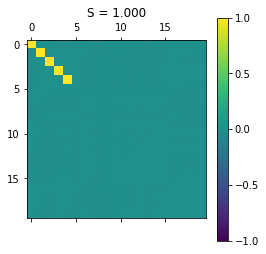

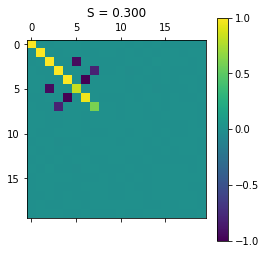

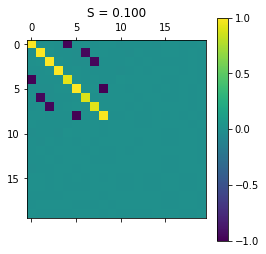

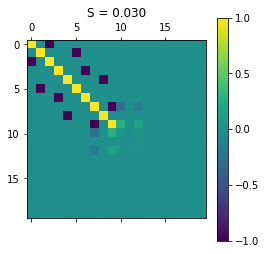

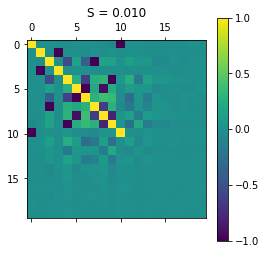

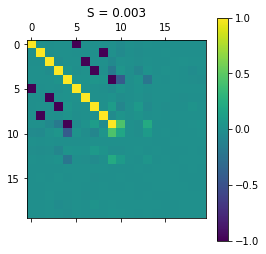

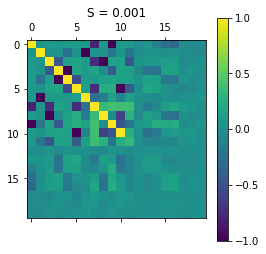

In [26]:
paint_WtW(no_linear_model, S)

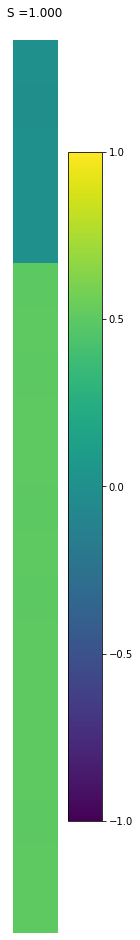

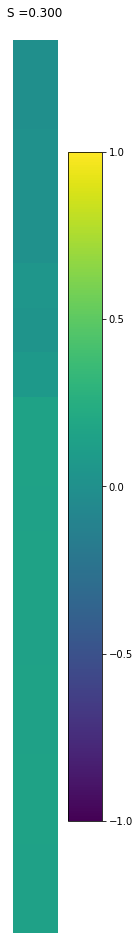

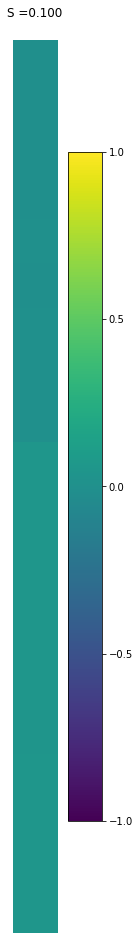

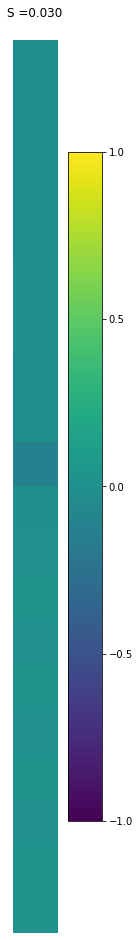

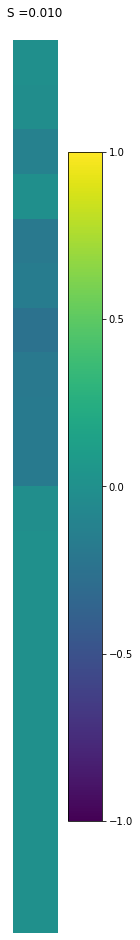

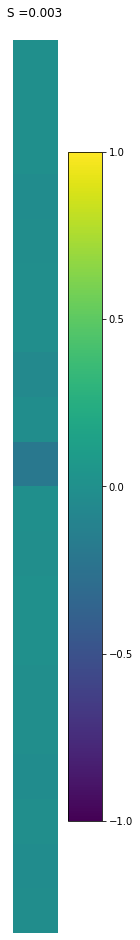

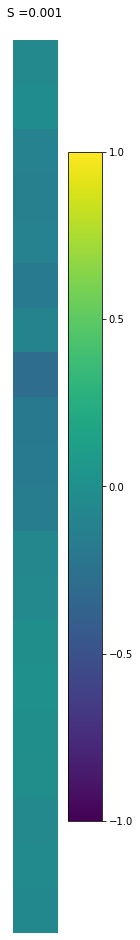

In [27]:
paint_b(no_linear_model, S)


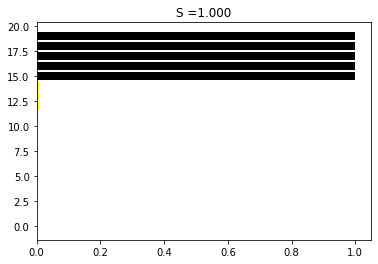

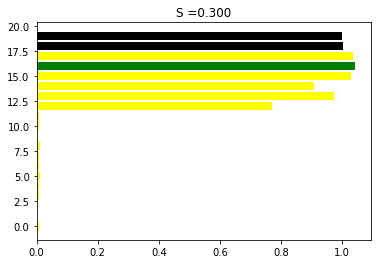

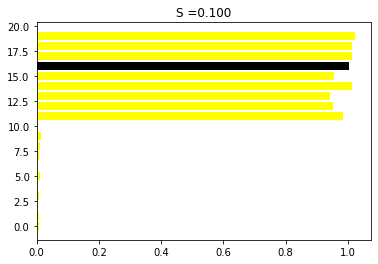

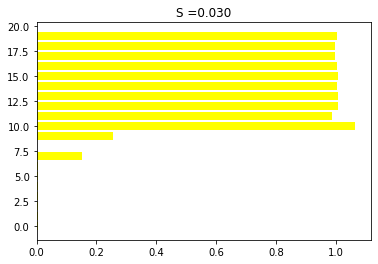

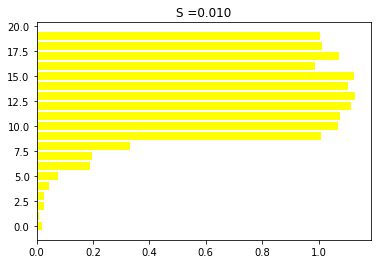

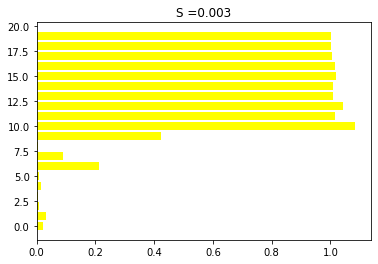

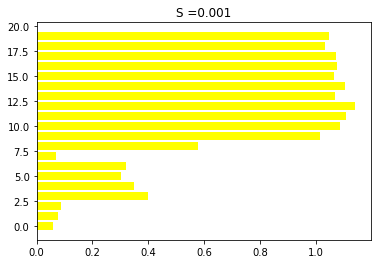

In [31]:
ch = paint_norm(no_linear_model,n)

# n = 80, m = 20, I = 0.9, num = 10000

In [34]:
n = 80
m = 20
I = 0.9
num = 10000
S = torch.tensor(([[1.0], [0.3], [0.1], [0.03], [0.01], [0.003], [0.001]]))

#S = (20 ** -torch.linspace(0, 1, n_instances))[:, None]

n_instances = len(S)


X = np.random.rand(num, n)
importances = torch.tensor([I**k for k in range(n)])

In [39]:
no_linear_model_2 = learning(Model(n, m, S,  n_instances), X, importances, n, 10000)

100%|████████████████████████████████████| 10000/10000 [00:20<00:00, 480.77it/s]


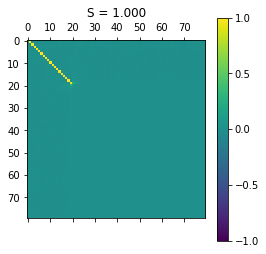

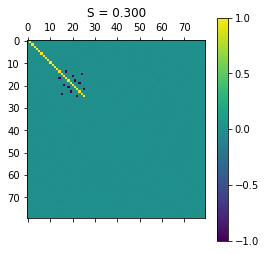

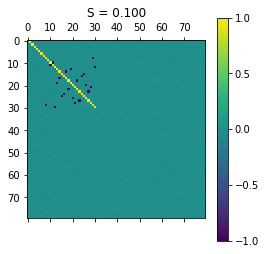

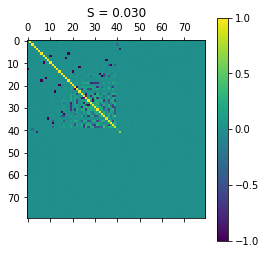

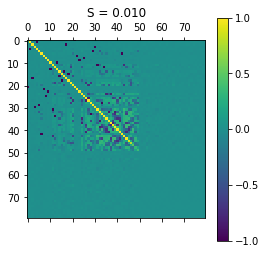

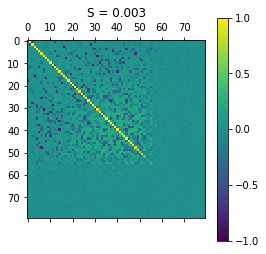

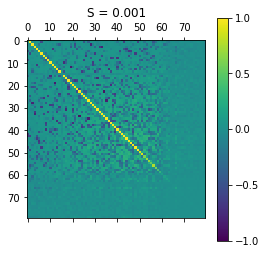

In [40]:
paint_WtW(no_linear_model_2, S)

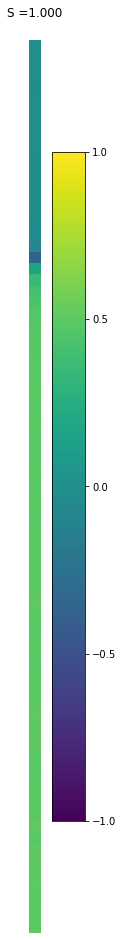

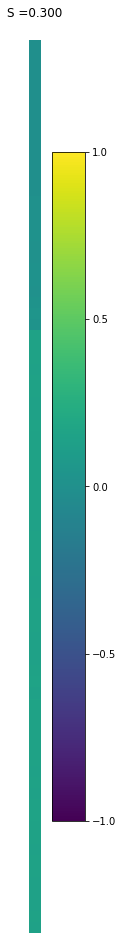

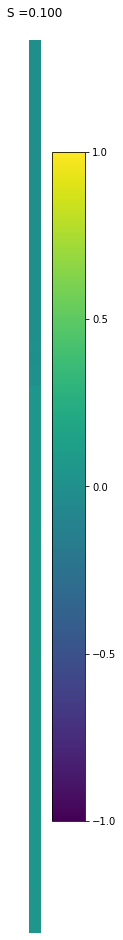

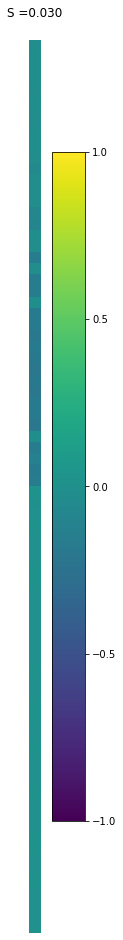

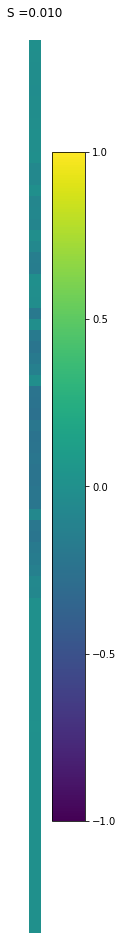

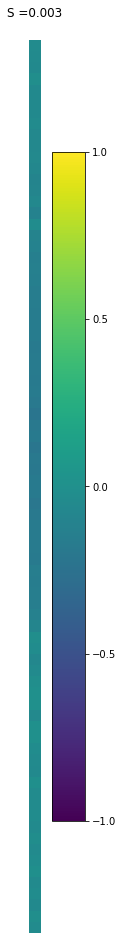

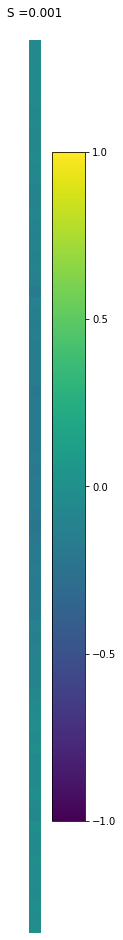

In [41]:
paint_b(no_linear_model_2, S)


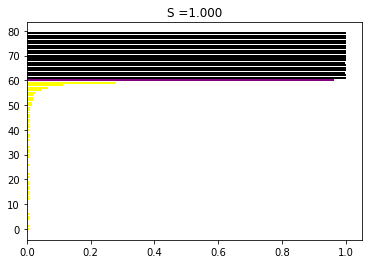

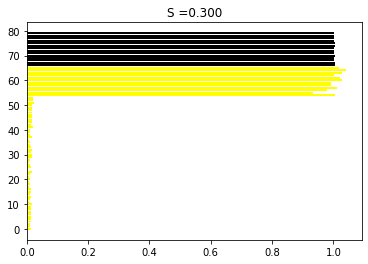

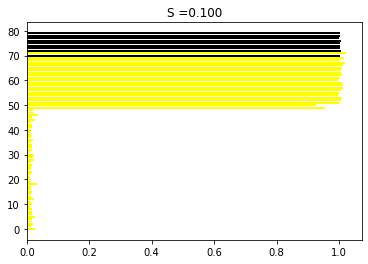

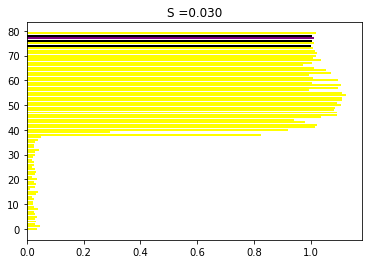

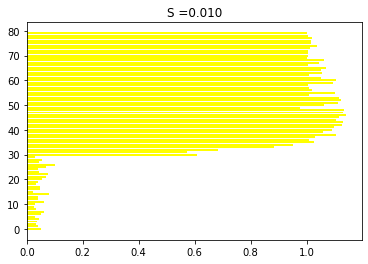

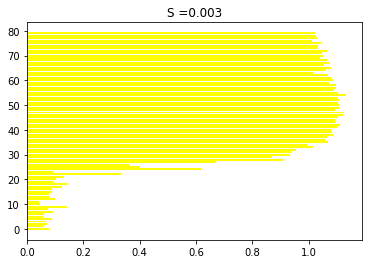

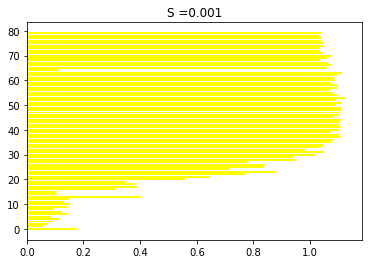

In [43]:
ch = paint_norm(no_linear_model_2,n)